In [1]:
import torch

def get_device():
    if torch.cuda.is_available():
        !nvidia-smi
        device = torch.device("cuda:0")
        print("Running on the GPU")
    else:
        device = torch.device("cpu")
        print("Running on the CPU")
    return device

device = get_device()

Fri May 26 18:21:48 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.73.05    Driver Version: 510.73.05    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 5000     Off  | 00000000:00:05.0 Off |                  Off |
| 34%   30C    P8    11W / 230W |      3MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Cargar el dataset
En este caso como vamos a entrenar un Autoencoder, vamos a utilizar todo el conjunto de datos
por lo que no es necesario tener train, valid y test como conjuntos para entrenar y validar.

In [2]:
import torchvision.datasets as datasets
from torchvision import transforms

# Normalizamos las imágenes en rango de 0 y 1
transform = transforms.Compose([
    transforms.ToTensor(),
])

root = "./data"

# Cargar dataset (original) y normalizar
mnist_trainset = datasets.MNIST(root=root, train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root=root, train=False, download=True, transform=transform)

In [3]:
from torch.utils.data import DataLoader

batch_size = 128

train_data = DataLoader(mnist_trainset, batch_size=batch_size, shuffle=True)
test_data = DataLoader(mnist_testset, batch_size=batch_size, shuffle=False)

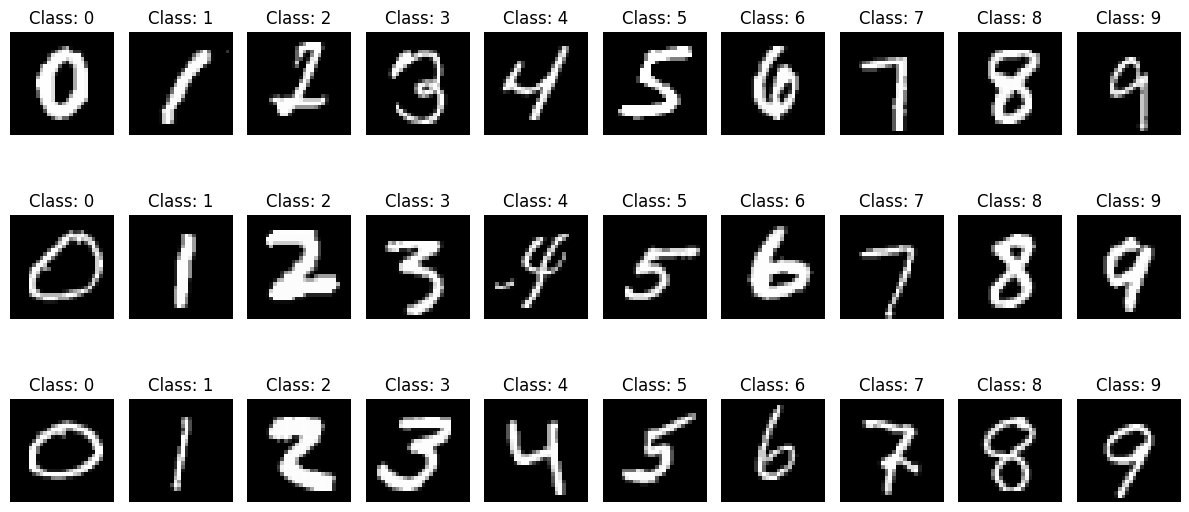

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_random(data):
    images, labels = next(iter(data))
    image_array = images.numpy()
    label_array = labels.numpy()

    classes = np.unique(label_array)

    plt.figure(figsize=(12, 6))

    for i, cls in enumerate(classes):
        class_indices = np.where(label_array == cls)[0]
        random_indices = np.random.choice(class_indices, size=3, replace=False)
        random_images = image_array[random_indices]

        for j, random_image in enumerate(random_images):
            plt.subplot(3, len(classes), j*len(classes) + i + 1)
            plt.imshow(random_image.squeeze(), cmap='gray')
            plt.title(f"Class: {cls}")
            plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_random(train_data)

# Agregar ruido
Ya vimos las imágenes de normales, por lo que ahora vamos a agregar ruido a cada imagen.
Estas imágenes son con las cuales se va a entrenar el autoencoder.

In [5]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [6]:
import torchvision.datasets as datasets
from torchvision import transforms

noise_level = 0.35

# Normalizamos las imágenes en rango de 0 y 1
transform_noisy=transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.1307,), (0.3081,)),
    AddGaussianNoise(0., noise_level)
])

# Cargar dataset y normalizar
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform_noisy)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform_noisy)

In [7]:
from torch.utils.data import DataLoader

batch_size = 128

noisy_train = DataLoader(mnist_trainset, batch_size=batch_size, shuffle=True)
noisy_test = DataLoader(mnist_testset, batch_size=batch_size, shuffle=False)

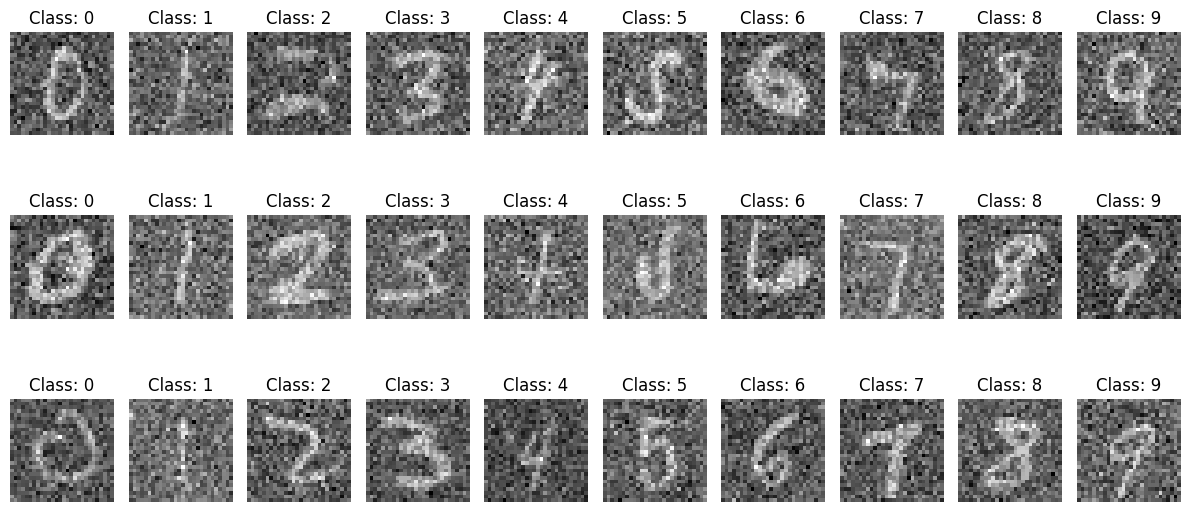

In [8]:
visualize_random(noisy_train)

In [9]:
import torch
import torch.nn as nn


class Encoder(nn.Module):
    def __init__(self, in_channels: int, out_channels: int) -> None:
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.01),
            nn.Conv2d(
                in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1
            ),
            nn.LeakyReLU(0.01),
            nn.Conv2d(
                in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1
            ),
            nn.LeakyReLU(0.01),
            nn.Conv2d(
                in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1
            ),
            nn.Flatten(),
            nn.Linear(1024, 128),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.encoder(x)
        return x


In [10]:
import torch
import torch.nn as nn


class Reshape(nn.Module):
    def __init__(self, *args) -> None:
        super().__init__()
        self.shape = args

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x.view(self.shape)


class Trim(nn.Module):
    def __init__(self, *args) -> None:
        super().__init__()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x[:, :, :28, :28]


class Decoder(nn.Module):
    def __init__(self, in_channels: int, out_channels: int) -> None:
        super().__init__()

        self.decoder = nn.Sequential(
            nn.Linear(128, 3136),
            Reshape(-1, 64, 7, 7),
            nn.ConvTranspose2d(
                in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1
            ),
            nn.LeakyReLU(0.01),
            nn.ConvTranspose2d(
                in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1
            ),
            nn.LeakyReLU(0.01),
            nn.ConvTranspose2d(
                in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=0
            ),
            nn.LeakyReLU(0.01),
            nn.ConvTranspose2d(
                in_channels=32,
                out_channels=out_channels,
                kernel_size=3,
                stride=2,
                padding=0,
            ),
            Trim(),
            nn.Sigmoid(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.decoder(x)
        return x


In [11]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self, encoder: Encoder, decoder: Decoder, device) -> None:
        super().__init__()

        self.encoder = encoder
        self.encoder.to(device)

        self.decoder = decoder
        self.decoder.to(device)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [12]:
denoising = DenoisingAutoencoder(Encoder(1, 2), Decoder(2, 1), device).to(device)
print(denoising)

DenoisingAutoencoder(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): LeakyReLU(negative_slope=0.01)
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): LeakyReLU(negative_slope=0.01)
      (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (7): Flatten(start_dim=1, end_dim=-1)
      (8): Linear(in_features=1024, out_features=128, bias=True)
    )
  )
  (decoder): Decoder(
    (decoder): Sequential(
      (0): Linear(in_features=128, out_features=3136, bias=True)
      (1): Reshape()
      (2): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): LeakyReLU(negative_slope=0.01)
      (4): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): LeakyReLU(negativ

In [14]:
import torch.optim as optim
import torch.nn.functional as F


criterion = nn.MSELoss()
optimizer = optim.Adam(denoising.parameters(), lr=1e-3)

def train(model, epochs):
    imaaaaages = []

    log_dict = {
        'training_loss_per_batch': [],
        'validation_loss_per_batch': [],
        'visualizations': []
    } 

    for epoch in range(epochs):
        model.train()
        for batch_idx, (original, noisy) in enumerate(zip(train_data, noisy_train)):
            image, _ = original
            noisy_image, _ = noisy

            image = image.to(device)
            noisy_image = noisy_image.to(device)

            outputs = model(noisy_image)

            loss = criterion(outputs, image)
            loss.backward()
            optimizer.step()

            log_dict['training_loss_per_batch'].append(loss.item())

        # Validation
        with torch.no_grad():
            for (original, noisy) in zip(test_data, noisy_test):
                image, _ = original
                noisy_image, _ = noisy

                image = image.to(device)
                noisy_image = noisy_image.to(device)

                outputs = model(noisy_image)

                val_loss = criterion(outputs, image)
        
        log_dict['validation_loss_per_batch'].append(loss.item())

        print(f'training_loss: {round(loss.item(), 4)} validation_loss: {round(val_loss.item(), 4)}')

        imaaaaages.append((image.to('cpu'), noisy_image.to('cpu'), outputs.to('cpu')))

    return imaaaaages

x = train(denoising, 10)

training_loss: 0.1126 validation_loss: 0.1452
training_loss: 0.1158 validation_loss: 0.1452
training_loss: 0.1211 validation_loss: 0.1452
training_loss: 0.1131 validation_loss: 0.1452
training_loss: 0.1038 validation_loss: 0.1452
training_loss: 0.1007 validation_loss: 0.1452
training_loss: 0.1158 validation_loss: 0.1452
training_loss: 0.1171 validation_loss: 0.1452
training_loss: 0.1179 validation_loss: 0.1452
training_loss: 0.106 validation_loss: 0.1452


In [30]:
original_image = x[-1][0][0]
noisy_image = x[-1][1][0]
reconstructed_image = x[-1][2][0]

In [33]:
print(original_image.shape)
print(noisy_image.shape)
print(reconstructed_image.shape)

torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])


In [34]:
to_pill = transforms.ToPILImage()

original_image = to_pill(original_image)
noisy_image = to_pill(noisy_image)
reconstructed_image = to_pill(reconstructed_image)

original_image

In [35]:
noisy_image

In [36]:
reconstructed_image